# Chapter 1

### 目標: generated modelを作成し，VDP+ $x_{lorenz}$モデルで100期先の予測を達成する．

問題設定：
VDP+ $x_{lorenz}$を計測し，学習期間とする．外力であるlorenzモデルの実データは（未来を含めて）既知とする．

課題：Generative Modelを用いて，VDP+ $x_{lorenz}$モデルで100期先の予測を達成する．

注意．
1. 関数として定義して，異なるデータ（sin wave，Doublescroll Attractor, VDP+sin $\omega t$, VDP+ $x_{lorenz}$ ）に対してもうまく作動するように設計する．
2. 周期的なモデルに対しては精度の良い予測を持つこと
3. 外力の値は常に実データで更新し続けること

#### 目標達成のためのアイディア

1. チュートリアルの方法と，今ままでに自作した方法で，差がないか考える（方法に間違いがないか）．
2. VDPの未来の予測値に関してもhyperoptで最適化を試みる．
3. （hybrid）既知の内容は：

・学習期間（過去から現在まで）のVDPの実際のデータ

・全ての外力の実際のデータ

よって，hyperoptでは学習期間における全ての実データと予測値のnrmseの最適化と，未来におけるlorenzの実データと予測値のnrmseの最適化の二つを考える．例えば，generated modelでlorenzの予測も精度が悪くなってしまう場合は，lorenzの未来に渡るデータをtrain_dataとして用いることで，それらの項に関しては良い精度を保つ．VDPのX, Y項に関してはその予測の精度の範囲に制約を受ける形で予測を行い，精度を保つ．

→lorenzがどれくらいdeviateしていくかを調べる．


# Step 1: チュートリアルの再現と関数化

ここでは，reservoirpyのチュートリアルのうち，

・2-Advanced_Features.ipynb

・3-General_Introduction_to_Reservoir_Computing.ipynb

を参考にして,データに対するgenerative modelを関数として定義する．

In [850]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

In [851]:
#def reset_esn()の定義
#reset_esn()は一体何に使うのか？

def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(1, ridge=regularization)

    return reservoir >> readout

In [852]:
# 描画用のplot_generationの定義

def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend(
    )
    plt.show()

In [853]:
"""def generative_model(X, N, iss, lr, ridge, seed, sr, forecast = 1, train_len = 2000, seed_timesteps = 100, nb_generations = 400):
    
    
    n, m = X.shape
    
    # モデルの構築
    reservoir = Reservoir(N, 
                        sr=sr, 
                        lr=lr, 
                        input_scaling=iss, 
                        seed=seed)
    readout = Ridge(ridge=ridge)
    esn = reservoir >> readout
        
    from reservoirpy.datasets import to_forecasting
    
    x, y = to_forecasting(X, forecast=forecast)
    X_train, y_train = x[:train_len], y[:train_len]
    X_test, y_test = x[train_len:], y[train_len:]   
    
    # モデルの訓練と予測
    esn = esn.fit(X_train, y_train)
    
    seed_timesteps = 100

    warming_inputs = X_test[:seed_timesteps]

    warming_out = esn.run(warming_inputs, reset=True)  # warmup
    
    nb_generations = 400

    X_gen = np.zeros((nb_generations, m))
    y = warming_out[-1]
    for t in range(nb_generations):  # generation
        y = esn(y)
        X_gen[t, :] = y
        
    X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]

    return X_gen, X_t, warming_out, warming_inputs
"""

'def generative_model(X, N, iss, lr, ridge, seed, sr, forecast = 1, train_len = 2000, seed_timesteps = 100, nb_generations = 400):\n    \n    \n    n, m = X.shape\n    \n    # モデルの構築\n    reservoir = Reservoir(N, \n                        sr=sr, \n                        lr=lr, \n                        input_scaling=iss, \n                        seed=seed)\n    readout = Ridge(ridge=ridge)\n    esn = reservoir >> readout\n        \n    from reservoirpy.datasets import to_forecasting\n    \n    x, y = to_forecasting(X, forecast=forecast)\n    X_train, y_train = x[:train_len], y[:train_len]\n    X_test, y_test = x[train_len:], y[train_len:]   \n    \n    # モデルの訓練と予測\n    esn = esn.fit(X_train, y_train)\n    \n    seed_timesteps = 100\n\n    warming_inputs = X_test[:seed_timesteps]\n\n    warming_out = esn.run(warming_inputs, reset=True)  # warmup\n    \n    nb_generations = 400\n\n    X_gen = np.zeros((nb_generations, m))\n    y = warming_out[-1]\n    for t in range(nb_generations):  #

In [854]:
"""X_gen_result, X_t_result, warming_out_result, warming_inputs_result = generative_model(X, 500, 1.0, 0.3, 1e-4, 1234, 0.99, 1, 2000, 100, 400)"""

'X_gen_result, X_t_result, warming_out_result, warming_inputs_result = generative_model(X, 500, 1.0, 0.3, 1e-4, 1234, 0.99, 1, 2000, 100, 400)'

In [855]:
"""X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]
plot_generation(X_gen, X_t, nb_generations, warming_out=warming_out,
                warming_inputs=warming_inputs, seed_timesteps=seed_timesteps)
"""

'X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]\nplot_generation(X_gen, X_t, nb_generations, warming_out=warming_out,\n                warming_inputs=warming_inputs, seed_timesteps=seed_timesteps)\n'

# Generative Modelの定義


In [856]:
def multi_generative_model(X, N, iss, lr, ridge, seed, sr, train_len = 2000, forecast=1, seed_timesteps = 100, nb_generations = 400):
    
    n, m = X.shape
    
    from reservoirpy.datasets import to_forecasting

    train_len = train_len

    x, y = to_forecasting(X, forecast=forecast)
    X_train, y_train = x[:2000], y[:2000]
    X_test, y_test = x[2000:], y[2000:]

    dataset = ((X_train, y_train), (X_test, y_test))
    
    # bestから取得したハイパーパラメータを設定
    N = N
    iss = iss
    lr = lr
    ridge = ridge
    seed = seed
    sr = sr

    # データセットからトレーニングとバリデーションデータを取得
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data

    # モデルの構築
    reservoir = Reservoir(N, 
                        sr=sr, 
                        lr=lr, 
                        input_scaling=iss, 
                        seed=seed)
    readout = Ridge(ridge=ridge)
    model = reservoir >> readout

    # モデルの訓練と予測
    predictions = model.fit(X_train, y_train).run(X_val)
    
    seed_timesteps = seed_timesteps

    warming_inputs = X_test[:seed_timesteps]

    warming_out = model.run(warming_inputs, reset=True)  # warmup
    
    nb_generations = nb_generations

    X_gen = np.zeros((nb_generations, m))
    y = warming_out[-1]
    for t in range(nb_generations):  # generation
        y = model(y)
        X_gen[t, :] = y
        
    X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]
    
    return X_gen, X_t, warming_out, warming_inputs

## Mackey-Glassの場合（１変数）

In [857]:
# 実データの取得
from reservoirpy.datasets import mackey_glass
from reservoirpy.observables import nrmse, rsquare

timesteps = 2510
tau = 17
X = mackey_glass(timesteps, tau=tau)

# rescale between -1 and 1
X = 2 * (X - X.min()) / (X.max() - X.min()) - 1

In [858]:
X_gen, X_t, warming_out, warming_inputs = multi_generative_model(X, 500, 1.0, 0.3, 1e-4, 1234, 0.99, 2000, 1, 100, 400)

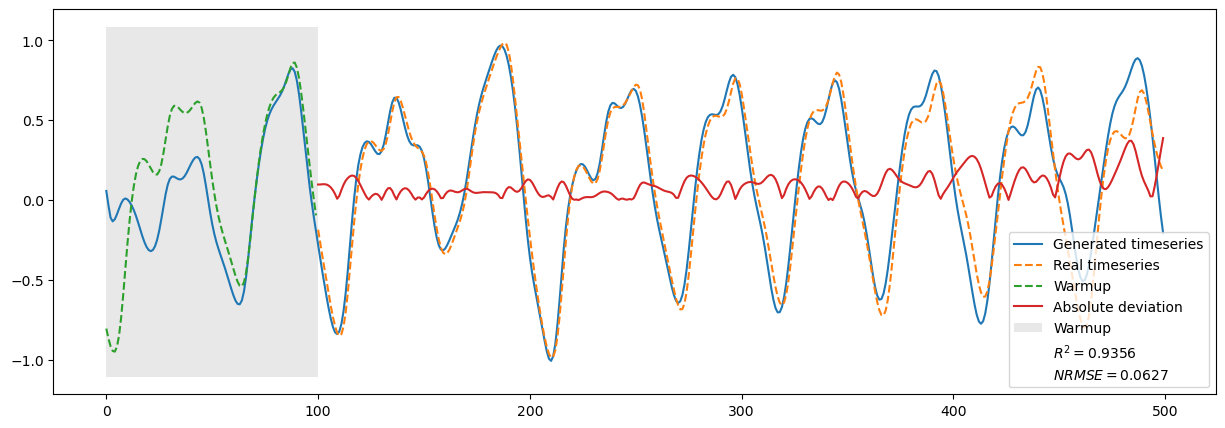

In [859]:
plot_generation(X_gen, X_t, nb_generations, warming_out=warming_out,
                warming_inputs=warming_inputs, seed_timesteps=seed_timesteps)


これで，Mackey-Glassの場合にGenerative Modelがうまく作動することを確認できた．
次に，Double Scroll Attractorについて試してみる．

## Double Scroll Attractorの場合（2変数）

In [860]:
from reservoirpy.datasets import doublescroll

timesteps = 2510
x0 = [0.37926545, 0.058339, -0.08167691]
X = doublescroll(timesteps, x0=x0, method="RK23")

In [861]:
X_gen, X_t, warming_out, warming_inputs = multi_generative_model(X, 500, 0.9, 0.8310012558635558, 1e-7, 1234, 0.2237449778907503, 2000, 1, 100, 400)

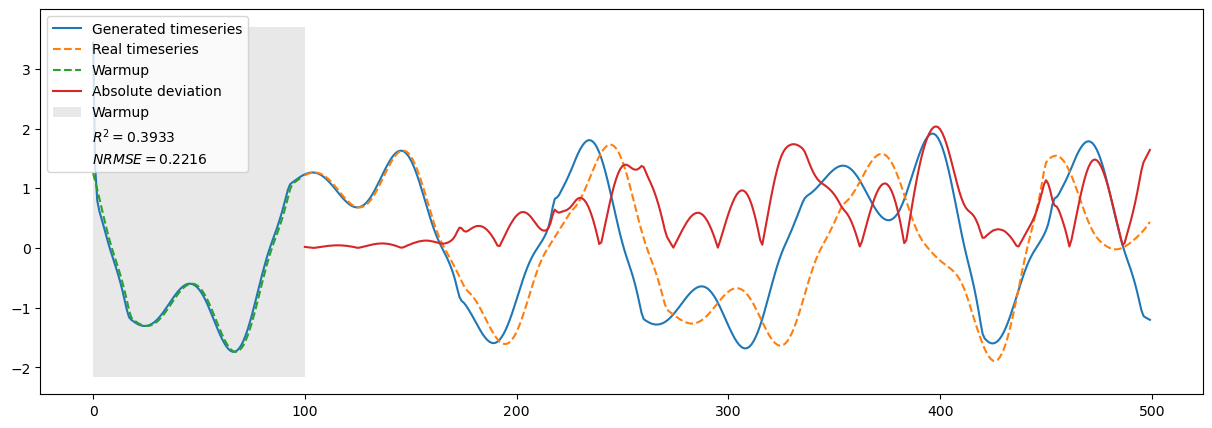

In [862]:
#Double Scroll AttractorのXを描画する
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)

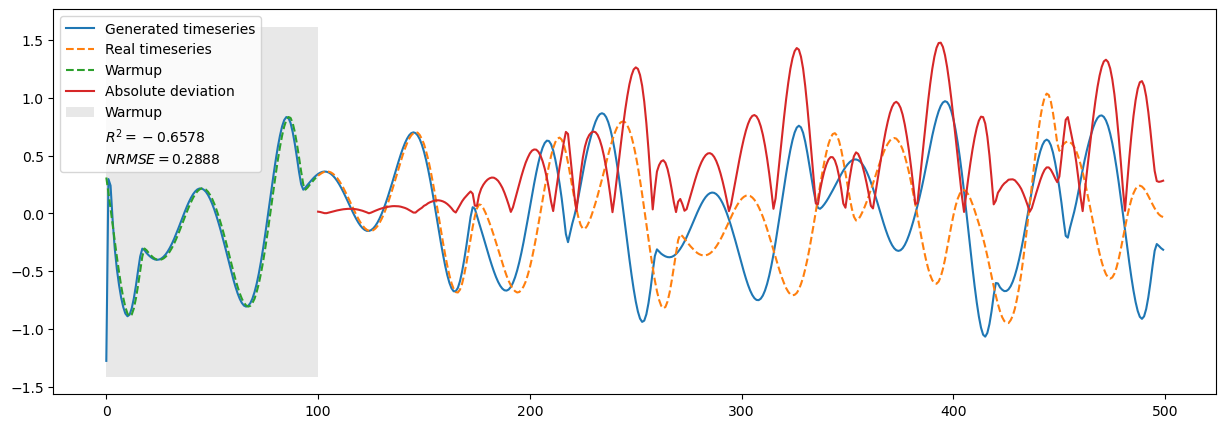

In [863]:
#Double Scroll AttractorのYを描画する
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)

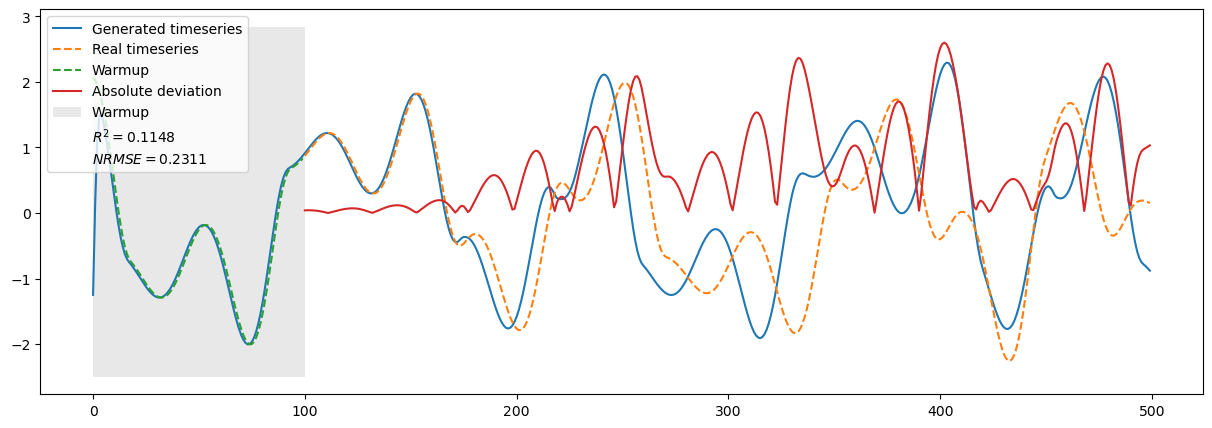

In [864]:

#Double Scroll AttractorのZを描画する
plot_generation(X_gen[:, 2:3], X_t[:, 2:3], nb_generations, warming_out=warming_out[:, 2:3],
                warming_inputs=warming_inputs[:, 2:3], seed_timesteps=seed_timesteps)

これで，Double Scroll Attractorの場合にGenerative Modelがうまく作動することを確認できた．
次に，VDPのsin項が外力に含まれる場合について試してみる．

## VDPのsin項が外力に含まれる場合

In [865]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt

def forced_van_der_pol(t, z, mu, A, omega):
    x, y, s_current = z  # Unpack the values
    dxdt = y
    dydt = mu * (1 - x**2) * y - x + A * np.sin(omega * t)
    s = np.sin(omega * t)
    return [dxdt, dydt, s]

mu = 1.0
A = 1.0
omega = 1.0
initial_state = [1.0, 0.0, 0.0]
t_span = (0, 2510)

sol = solve_ivp(forced_van_der_pol, t_span, initial_state, args=(mu, A, omega), dense_output=True, t_eval=np.linspace(t_span[0], t_span[1], 25100), max_step = 0.01)

t = sol.t
z = sol.y

# CSVファイルにデータを保存
data = pd.DataFrame({'Time': t, 'x': z[0], 'y': z[1], 'sin':z[2]})
data.to_csv('forced_vanderpol_dataset.csv', index=False)

data_withouttime = pd.DataFrame({'x': z[0], 'y': z[1], 'sin':z[2]})


# CSVファイルを読み込む
data_loaded = pd.read_csv('forced_vanderpol_dataset.csv')

X = data_withouttime.values

In [866]:
X_gen, X_t, warming_out, warming_inputs = multi_generative_model(X, 500, 0.8644046911873131, 0.6156368875066843, 8.186416440991658e-08, 1234, 1.6722388684853167, 3000, 1, 100, 400)

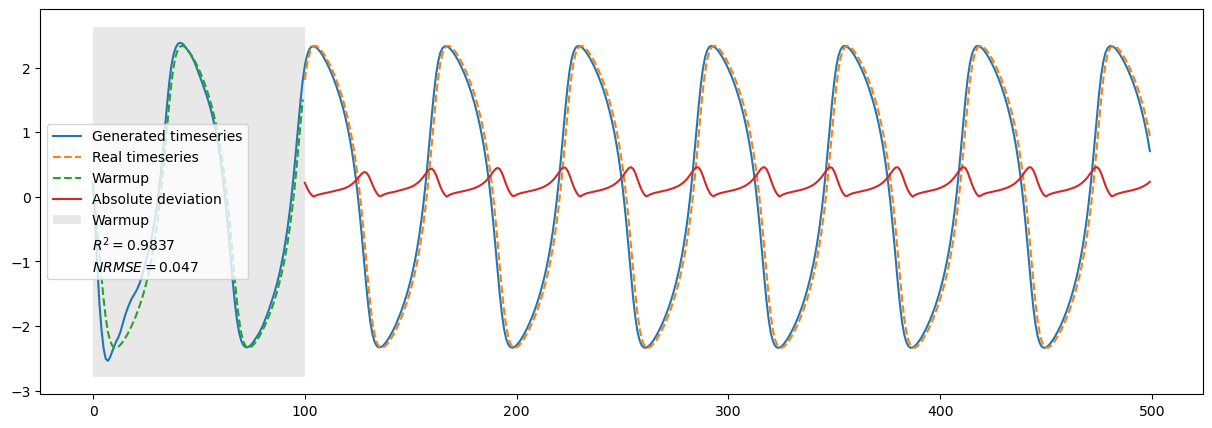

In [867]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)

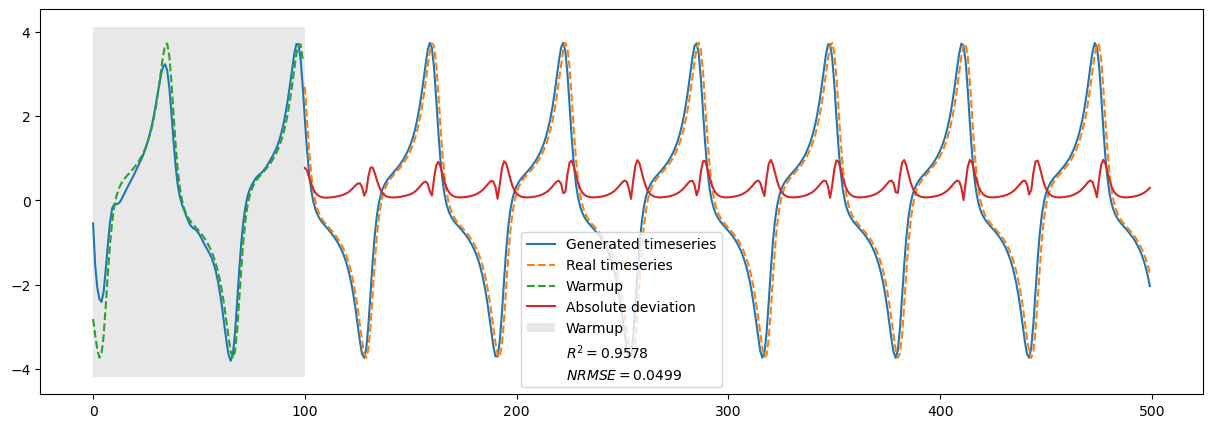

In [868]:
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)


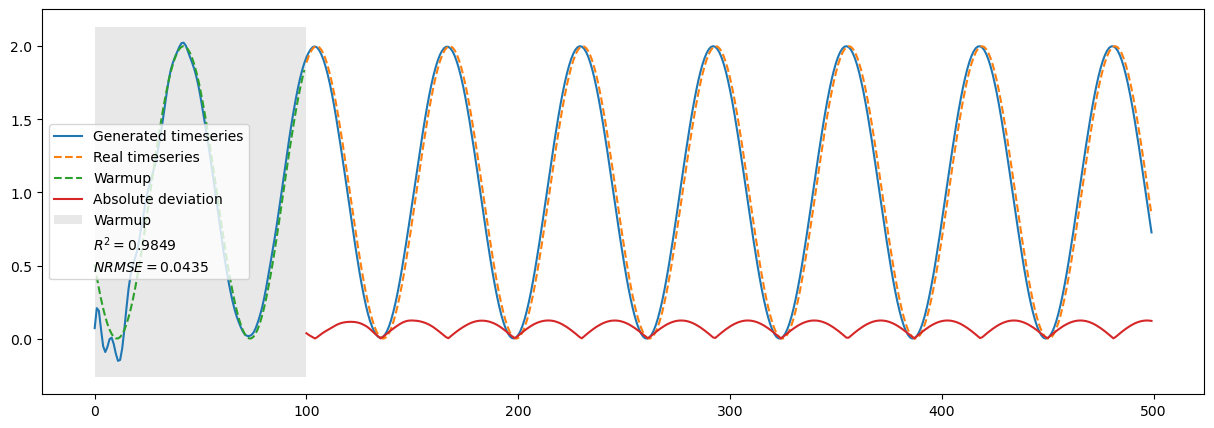

In [869]:
plot_generation(X_gen[:, 2:3], X_t[:, 2:3], nb_generations, warming_out=warming_out[:, 2:3],
                warming_inputs=warming_inputs[:, 2:3], seed_timesteps=seed_timesteps)


これで，VDPのsin項が外力に含まれる場合にGenerative Modelがうまく作動することを確認できた．
次に，VDPのlorenzのx項が外力に含まれる場合について試してみる．

## VDPのlorenzのx項が外力に含まれる場合

In [870]:
from scipy.integrate import solve_ivp

def coupled_system(t, state, mu, sigma, rho, beta):
    X, Y, x_lorenz, y_lorenz, z_lorenz = state
    
    dXdt = Y
    dYdt = mu * (1 - X**2) * Y - X + x_lorenz
    
    dx_lorenz_dt = sigma * (y_lorenz - x_lorenz)
    dy_lorenz_dt = x_lorenz * (rho - z_lorenz) - y_lorenz
    dz_lorenz_dt = x_lorenz * y_lorenz - beta * z_lorenz
    
    return [dXdt, dYdt, dx_lorenz_dt, dy_lorenz_dt, dz_lorenz_dt]

mu = 1.0
sigma = 10.0
rho = 28.0
beta = 8/3
initial_state = [1.0, 0.0, 1.0, 1.0, 1.0]  # Initial states for [X, Y, x_lorenz, y_lorenz, z_lorenz]
t_span = (0, 2510)

sol = solve_ivp(coupled_system, t_span, initial_state, args=(mu, sigma, rho, beta), t_eval=np.linspace(t_span[0], t_span[1], 25100), max_step = 0.01)

#Time, Van Der Pol　OscillatorのX, lorenzのx項のみを抽出、学習。

data = pd.DataFrame({
    'X': sol.y[0],
    'Y': sol.y[1],
    'x_lorenz': sol.y[2],
    'y_lorenz': sol.y[3],
    'z_lorenz': sol.y[4]
})

# DataFrameをCSVファイルに保存
data.to_csv('coupled_system_dataset.csv', index=False)

X = data.values

In [871]:
X.shape

(25100, 5)

In [872]:
X_gen, X_t, warming_out, warming_inputs = multi_generative_model(X, 3849, 0.14258024657972923, 0.5516837456874331, 3.7433235003717447e-07, 1234, 0.1931498404234262)

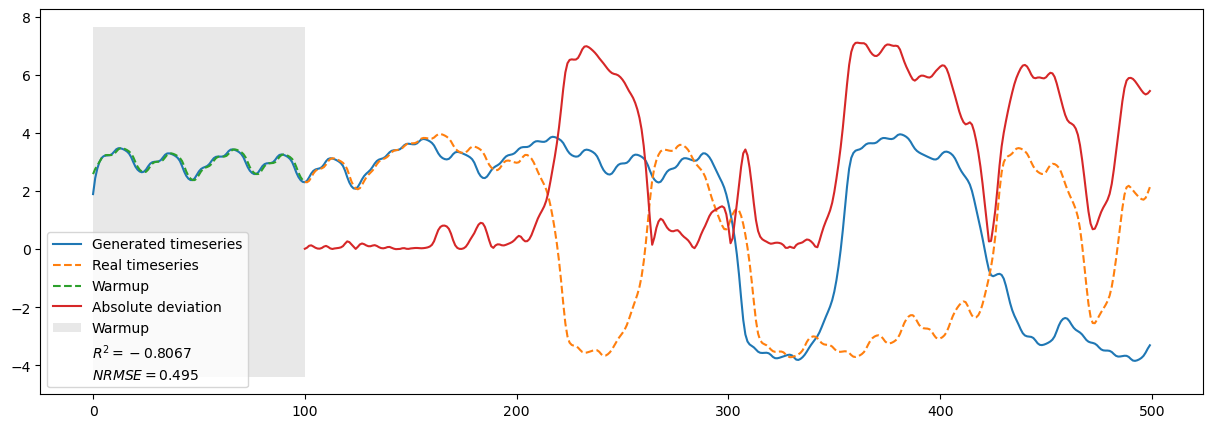

In [873]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)

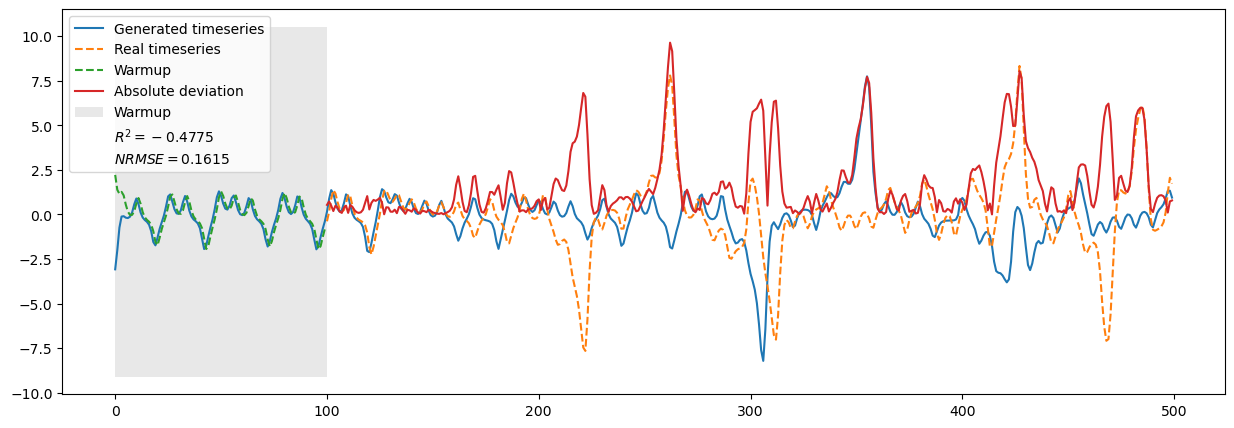

In [874]:
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)


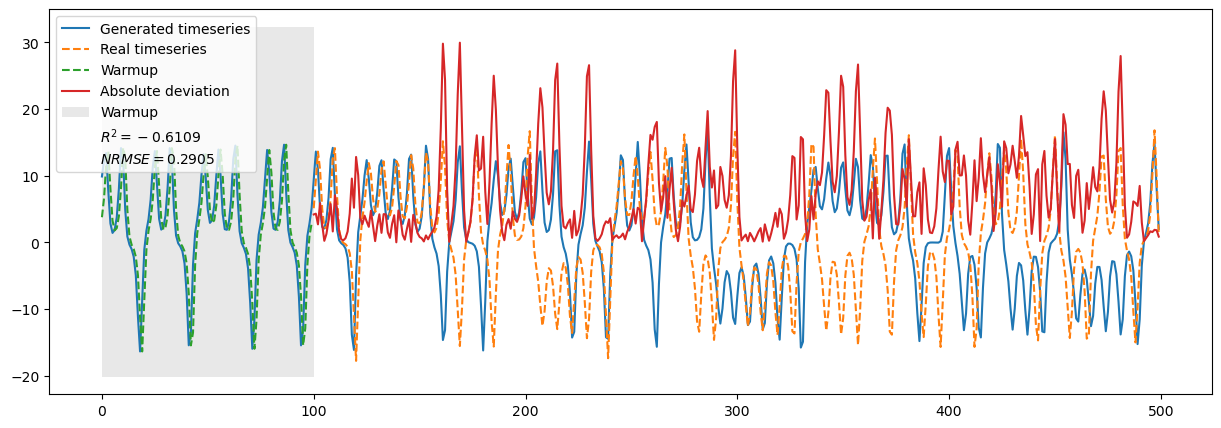

In [875]:
plot_generation(X_gen[:, 2:3], X_t[:, 2:3], nb_generations, warming_out=warming_out[:, 2:3],
                warming_inputs=warming_inputs[:, 2:3], seed_timesteps=seed_timesteps)


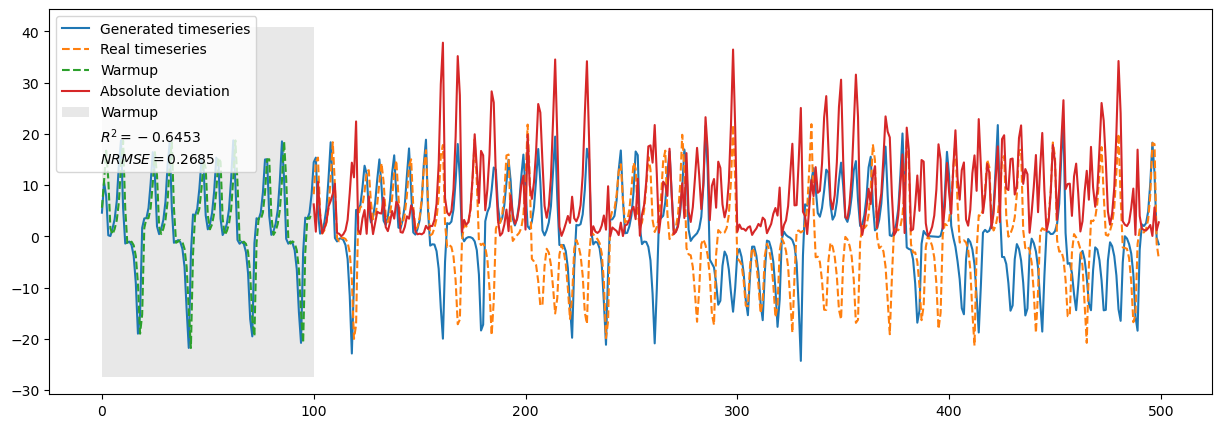

In [876]:
plot_generation(X_gen[:, 3:4], X_t[:, 3:4], nb_generations, warming_out=warming_out[:, 3:4],
                warming_inputs=warming_inputs[:, 3:4], seed_timesteps=seed_timesteps)


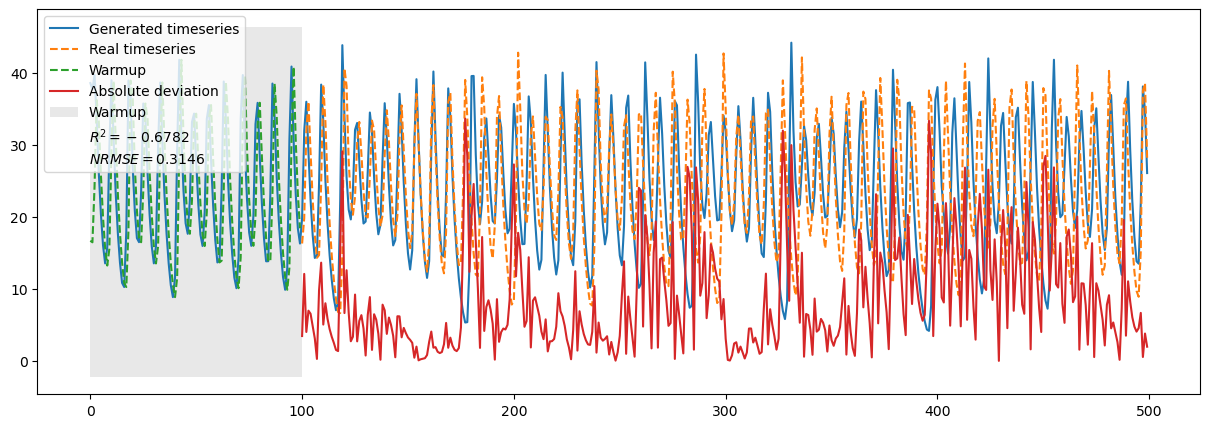

In [877]:
plot_generation(X_gen[:, 4:5], X_t[:, 4:5], nb_generations, warming_out=warming_out[:, 4:5],
                warming_inputs=warming_inputs[:, 4:5], seed_timesteps=seed_timesteps)


これで，VDPのlorenzのx項が外力に含まれる場合にGenerative Modelがうまく作動することを確認できた．

データ幅が$0.1$であることを考慮すると，約5~6ステップの間はVDPのX,Yの予測に成功しているようである（これは約1日に対応する）．
一方で，lorenzのx, y, z項を見るとそれよりずっと早く予測精度が悪くなってしまっている．よって，次のことが考えられる．

・lorenzに関しては予測データの更新ごとに実データを参照することで，精度が上がる可能性がある．

・lorenzの実データは全て既知であると仮定すると，esnの最適化（multi_generations_predではhyperparametersの値として現れる）で，予測期間を含めた期間の間，すなわちtrain_data $+$ nb_generationsの間でlorenzに関するnrmseも最適化の対象として考慮する．元々のVDPのX，Yの最適化も考える必要があるだろうから，その二つを重み付けして実現できるかもしれない．例えば，二つの誤差の量を線型結合でまとめて，その係数も最適化の対象に含めるなど．

# 今後の方針

1. lorenzに対して，multi_genを試してみる（すぐにできるはず）．
2. lorenzの値を更新するように上のコードを修正する．

Chapter 1
終わり